# Importing the Clear Data 

In [ ]:
# Import necessary modules
from os.path import exists
import subprocess

# Get platform details
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# Check for CUDA availability
cuda_output = subprocess.check_output('ldconfig -p | grep cudart.so | sed -e "s/.*\\.\([0-9]*\)\\.\([0-9]*\)$/cu\\1\\2/"', shell=True).decode('utf-8').strip()
accelerator = cuda_output if exists('/dev/nvidia0') else 'cpu'

# Install torch nightly build
# !pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html

# Import and check torch installation
# import torch
# print("Torch version:", torch.__version__)
# print("CUDA available:", torch.cuda.is_available())
# print("cuDNN enabled:", torch.backends.cudnn.enabled)

# Install fastai library
# !pip install fastai

# Import and check fastai installation
import fastai
print("Fastai version:", fastai.__version__)

# Import fastai vision and torchvision models
from fastai import *
from fastai.vision import *
from torchvision.models import *


# import required packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import random
import cv2
import math
import boto3
from pathlib import Path
import numpy as np
from PIL import Image
from skimage import io
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
from imutils import paths
%matplotlib inline

Looking in links: https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html
    100% |████████████████████████████████| 697.2MB 22kB/s 
1.0.0.dev20190322
True
True
    100% |████████████████████████████████| 17.3MB 2.2MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [ ]:
# Connect to AWS S3 using provided access key ID and secret access key
s3 = boto3.client('s3',
                  aws_access_key_id='***',
                  aws_secret_access_key='***',
                  region_name='us-east-2')

In [ ]:
# specific the bucket name within your s3
bucket_name = 'drprojectbucket'
source_prefix = 'train/'
destination_prefix = 'validation/'

# List of class folders
classes = ['0', '1', '2', '3', '4']

In [ ]:
# Function to get all objects in a specific S3 prefix
def list_s3_objects(bucket, prefix):
    objects = []
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        if 'Contents' in page:
            for obj in page['Contents']:
                objects.append(obj['Key'])
    return objects

# Function to move an object from source to destination
def move_s3_object(bucket, source_key, destination_key):
    # Copy the object
    s3.copy_object(Bucket=bucket, CopySource={'Bucket': bucket, 'Key': source_key}, Key=destination_key)
    # Delete the original object
    # We need to delete the original object as AWS s3 doesnot the option to move, So we can only copy and then delete the original images
    s3.delete_object(Bucket=bucket, Key=source_key)

In [ ]:
# Create validation folders if they don't exist
for cls in classes:
    s3.put_object(Bucket=bucket_name, Key=f'{destination_prefix}{cls}/')

# Move random samples from train to validation
for cls in classes:
    source_folder = f'{source_prefix}{cls}/'
    destination_folder = f'{destination_prefix}{cls}/'
    
    # List all objects in the source folder
    objects = list_s3_objects(bucket_name, source_folder)
    
    # Select a random number of objects to move (e.g., 20% of objects)
    num_objects_to_move = int(0.2 * len(objects))
    objects_to_move = random.sample(objects, num_objects_to_move)
    
    for obj in objects_to_move:
        filename = Path(obj).name
        source_key = obj
        destination_key = f'{destination_folder}{filename}'
        move_s3_object(bucket_name, source_key, destination_key)
        # print(f'Moved {source_key} to {destination_key}')

In [ ]:
# Set S3 bucket details
BUCKET_NAME = 'drprojectbucket'
PREFIX = 'validation/'
val_LOCAL_PATH = './tmp/validation/'
train_LOCAL_PATH = './tmp/train/'

# Create local directory if it doesn't exist
Path(val_LOCAL_PATH).mkdir(parents=True, exist_ok=True)
Path(train_LOCAL_PATH).mkdir(parents = True, exist_ok = True)

In [ ]:
# Function to download images from S3
def download_images_from_s3(bucket, prefix, local_path):
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        if 'Contents' in page:
            for obj in page['Contents']:
                key = obj['Key']
                if not key.endswith('/'):
                    local_file_path = os.path.join(local_path, os.path.relpath(key, prefix))
                    Path(os.path.dirname(local_file_path)).mkdir(parents=True, exist_ok=True)
                    s3.download_file(bucket, key, local_file_path)
                    print(f'Downloaded {key} to {local_file_path}')

In [ ]:
# Download validation and train images from S3 to local directory
download_images_from_s3(BUCKET_NAME, PREFIX, val_LOCAL_PATH)
download_images_from_s3(BUCKET_NAME, PREFIX, train_LOCAL_PATH)

In [ ]:
# Specify model architecture, batch size, input size, and model path
arch = densenet201  # specify model architecture
bs = 12  # specify batch size
sz = 512  # input size is the crop size
MODEL_PATH = str(arch).split()[1]  # extract the model name as the model file name, e.g., 'densenet201'

In [ ]:
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch =   densenet201                 # specify model architecture, densenet169 seems to perform well for this data but you could experiment
bs = 10 # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = 512                      # input size is the crop size
#MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

In [ ]:
# Data transformations
tfms = get_transforms(do_flip=True, max_zoom=1.3)

In [ ]:
# Create ImageDataBunch from the local directory
data = ImageDataBunch.from_folder(
    './tmp',  # path to folder with images
    train='train',  # specify that the training images are in the 'train' folder
    valid='validation',  # specify that the validation images are in the 'validation' folder
    ds_tfms=tfms,  # apply transformations
    size=sz,  # resize images to `sz`
    bs=bs  # batch size
)

In [ ]:
# Normalize the data
data.normalize(imagenet_stats)

In [ ]:
# Define a function to create and return a learner object
def getLearner():
    # Create a Convolutional Neural Network (CNN) learner using fastai's cnn_learner function
    # Parameters:
    # - data: the data object created from ImageDataBunch, containing training and validation datasets
    # - arch: the architecture of the CNN model, in this case, densenet201
    # - pretrained: whether to use pretrained weights (True) or not (False)
    # - path: the path where the model will be saved ('.' indicates the current directory)
    # - metrics: the metrics to be used for evaluation during training, here it's accuracy
    # - ps: the dropout probability, 0.5 means 50% dropout
    # - callback_fns: a list of callback functions to be used during training, here it's ShowGraph to visualize training progress
    return cnn_learner(data, arch, pretrained=True, path='.', metrics=accuracy, ps=0.2, callback_fns=ShowGraph)

# Create a learner object by calling the getLearner function
learner = getLearner()


Model Architecture

In [ ]:
# Import the torchsummary library to display a summary of the model architecture
from torchsummary import summary

# Use the summary function from torchsummary to print a detailed summary of the model architecture
# Parameters:
# - learner.model: the model object within the learner, which contains the architecture of the neural network
# - (3, 512, 512): the shape of the input tensor, where 3 is the number of channels (for RGB images), 
#   and 512x512 is the spatial dimension of the images
summary(learner.model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]           8,192
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10         [-1, 32, 128, 128]          36,864
      BatchNorm2d-11         [-1, 96, 128, 128]             192
             ReLU-12         [-1, 96, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]          12,288
      BatchNorm2d-14        [-1, 128, 1

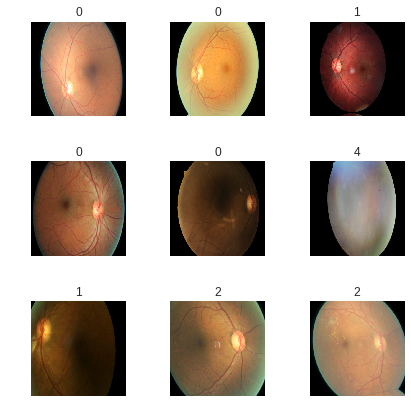

In [ ]:
# verify the data
# print(data.classes)
data.show_batch(rows=3, figsize=(6,6));

The learning rate we got from previous analysis

In [ ]:
# Define the maximum learning rate to be used during training
# max_lr (maximum learning rate) is set to 1e-3 (0.001)
# This is the highest learning rate that will be used by the learning rate scheduler

max_lr = 1e-3

# Define the weight decay parameter to be used during training
# wd (weight decay) is set to 1e-6
# Weight decay is a regularization technique that adds a penalty to the loss function to prevent overfitting
# It helps in controlling the complexity of the model by penalizing large weights

wd = 1e-6


Model fit

epoch,train_loss,valid_loss,accuracy,time
0,1.104533,1.052842,0.621869,45:09
1,0.920231,0.866202,0.673997,44:55
2,0.803812,0.777084,0.705559,45:03
3,0.764604,0.704630,0.733455,44:49
4,0.691905,0.677392,0.743637,44:47
5,0.680551,0.648187,0.755447,44:52
6,0.599412,0.619531,0.768275,44:48


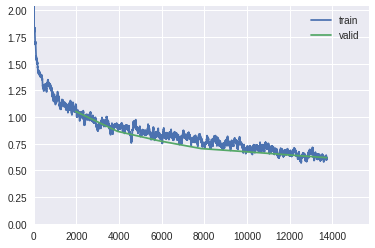

Buffered data was truncated after reaching the output size limit.

In [ ]:
# Fit the model using the 1cycle policy
# Parameters:
# - cyc_len: the length of the training cycle (number of epochs)
# - max_lr: the maximum learning rate to be used during training
# - wd: the weight decay parameter

# The 1cycle policy is a training technique that adjusts the learning rate in a cyclical manner.
# It helps the model to converge faster and achieve better performance by following these steps:
# 1. The learning rate increases from a lower bound to the maximum learning rate (max_lr) during the first phase.
# 2. The learning rate decreases from the maximum learning rate to a lower bound during the second phase.
# 3. The model is trained with these cyclical learning rates, which helps in better generalization and faster convergence.
# The 1cycle policy also includes optional momentum adjustments, where the momentum decreases
# during the first phase and increases during the second phase.

# Fit the model using the 1cycle policy for 8 epochs
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.757510,0.728719,0.730605,57:43
1,0.741443,0.660608,0.751578,57:34
2,0.683744,0.601534,0.767461,57:44
3,0.596244,0.591047,0.772551,57:55


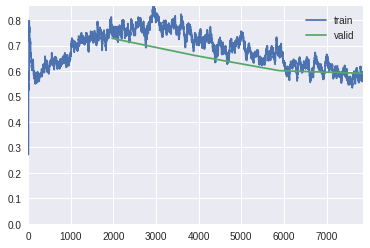

In [ ]:
# Define the maximum learning rate and weight decay parameters
max_lr = 3e-4  # Set the maximum learning rate to 3e-4

# Create a list of learning rates to use for different layers of the model
# Typically, lower layers have smaller learning rates while higher layers have larger learning rates
max_lrs = [max_lr / 9, max_lr / 3, max_lr]  # Divide the maximum learning rate for differential learning rates

# Create a list of weight decays to use for different layers of the model
wds = [wd / 9, wd / 3, wd]  # Divide the weight decay for differential weight decay rates

# Set the weight decay parameter
wd = 1e-6  # Set the weight decay to 1e-6

# Unfreeze the model to allow training of all layers
# In transfer learning, typically only the last layers are trained initially (with the rest frozen)
# Unfreezing allows all layers to be fine-tuned
learner.unfreeze()

# Fit the model using the 1cycle policy with differential learning rates and weight decays
# Parameters:
# - cyc_len: the length of the training cycle (number of epochs), set to 4 here
# - max_lr: the list of maximum learning rates for different layers
# - wd: the list of weight decay values for different layers

# The 1cycle policy helps in achieving better performance by cyclically varying the learning rate
# and optionally momentum. This approach prevents the model from overfitting and helps in faster convergence.

learner.fit_one_cycle(cyc_len=4, max_lr=max_lrs, wd=wds)


epoch,train_loss,valid_loss,accuracy,time
0,0.563727,0.533711,0.794339,56:48
1,0.590286,0.514370,0.804724,56:09
2,0.536467,0.500096,0.811647,56:23
3,0.490264,0.494299,0.813480,56:29


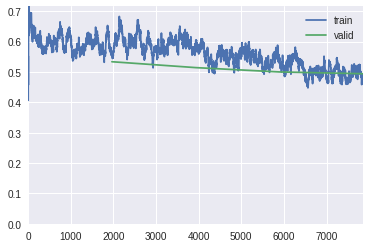

In [ ]:
# Define the maximum learning rate and weight decay parameters
max_lr = 1e-4  # Set the maximum learning rate to 1e-4

# Create a list of learning rates to use for different layers of the model
# Typically, lower layers have smaller learning rates while higher layers have larger learning rates
max_lrs = [max_lr / 9, max_lr / 3, max_lr]  # Divide the maximum learning rate for differential learning rates

# Create a list of weight decays to use for different layers of the model
wds = [wd / 9, wd / 3, wd]  # Divide the weight decay for differential weight decay rates

# Set the weight decay parameter
wd = 1e-6  # Set the weight decay to 1e-6

# Unfreeze the model to allow training of all layers
# In transfer learning, typically only the last layers are trained initially (with the rest frozen)
# Unfreezing allows all layers to be fine-tuned
learner.unfreeze()

# Fit the model using the 1cycle policy with differential learning rates and weight decays
# Parameters:
# - cyc_len: the length of the training cycle (number of epochs), set to 4 here
# - max_lr: the list of maximum learning rates for different layers
# - wd: the list of weight decay values for different layers

# The 1cycle policy helps in achieving better performance by cyclically varying the learning rate
# and optionally momentum. This approach prevents the model from overfitting and helps in faster convergence.

learner.fit_one_cycle(cyc_len=4, max_lr=max_lrs, wd=wds)


Confusion matrix

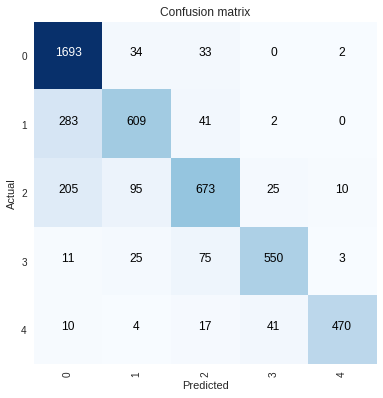

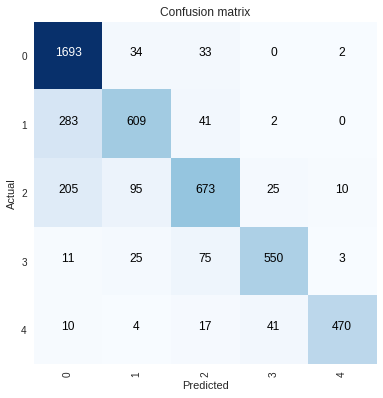

In [ ]:
# Generate the classification interpretation from the learner
# This will help us understand how well the model is performing and where it might be making mistakes
interp = ClassificationInterpretation.from_learner(learner)

# Plot the confusion matrix to visualize the model's performance
# A confusion matrix shows the number of correct and incorrect predictions made by the model
# It helps in identifying which classes are being misclassified
interp.plot_confusion_matrix(title='Confusion matrix')


The below code implements Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize the important regions of images that contribute to a model's predictions. It includes functions to hook into the forward and backward passes of the model, capturing activations and gradients needed to generate heatmaps. These heatmaps are overlaid on grayscale images to highlight key areas influencing the model's decisions. The plot_heatmap_overview function then creates a comprehensive visualization, displaying random samples, the most incorrect predictions, and the most correct predictions from the validation set. This aids in interpreting the model's performance and understanding its decision-making process.

In [ ]:
# Import necessary modules for hooks and visualization
from fastai.callbacks.hooks import *

# Define a function to hook into the forward pass of the model
def hooked_backward(m, oneBatch, cat):
    # Hook into the convolutional part of the model (m[0])
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)  # Get predictions for the batch
            preds[0, int(cat)].backward()  # Backpropagate the prediction for the correct class
    return hook_a, hook_g  # Return activation and gradient hooks

# Define a function to get the heatmap for a specific validation image
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # Set the model to evaluation mode
    m = learner.model.eval()
    tensorImg, cl = data.valid_ds[val_index]  # Get the image tensor and its true class
    oneBatch, _ = data.one_item(tensorImg)  # Create a batch from the single image
    oneBatch_im = vision.Image(data.denorm(oneBatch)[0])  # Denormalize the image
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)  # Convert image to grayscale with OpenCV
    hook_a, hook_g = hooked_backward(m, oneBatch, cl)  # Attach hooks to the model
    acts = hook_a.stored[0].cpu()  # Get convolutional activations

    # Grad-CAM: Compute gradient and weighted activation map
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    mult = (acts * grad_chan[..., None, None]).mean(0)  # Weighted sum of activations
    return mult, cvIm  # Return the activation map and the grayscale image

# Import random module to select random images
from random import randint

# Define a function to plot heatmaps for an overview of the model's performance
def plot_heatmap_overview(interp: ClassificationInterpretation, classes=['Negative', 'Tumor']):
    # Get top losses and corresponding indexes from the interpretation
    tl_val, tl_idx = interp.top_losses()
    fig, ax = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability', fontsize=20)

    # Plot random samples from validation set
    for i in range(4):
        random_index = randint(0, len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H, W = im.shape
        _, cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0, i].imshow(im)
        ax[0, i].imshow(im, cmap=plt.cm.gray)
        ax[0, i].imshow(act, alpha=0.5, extent=(0, H, W, 0), interpolation='bilinear', cmap='inferno')
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])
        ax[0, i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0, 0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)

    # Plot samples with the most incorrect predictions (top losses)
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H, W = im.shape
        _, cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1, i].imshow(im)
        ax[1, i].imshow(im, cmap=plt.cm.gray)
        ax[1, i].imshow(act, alpha=0.5, extent=(0, H, W, 0), interpolation='bilinear', cmap='inferno')
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])
        ax[1, i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1, 0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)

    # Plot samples with the most correct predictions (least losses)
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H, W = im.shape
        _, cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2, i].imshow(im)
        ax[2, i].imshow(im, cmap=plt.cm.gray)
        ax[2, i].imshow(act, alpha=0.5, extent=(0, H, W, 0), interpolation='bilinear', cmap='inferno')
        ax[2, i].set_xticks([])
        ax[2, i].set_yticks([])
        ax[2, i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2, 0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)


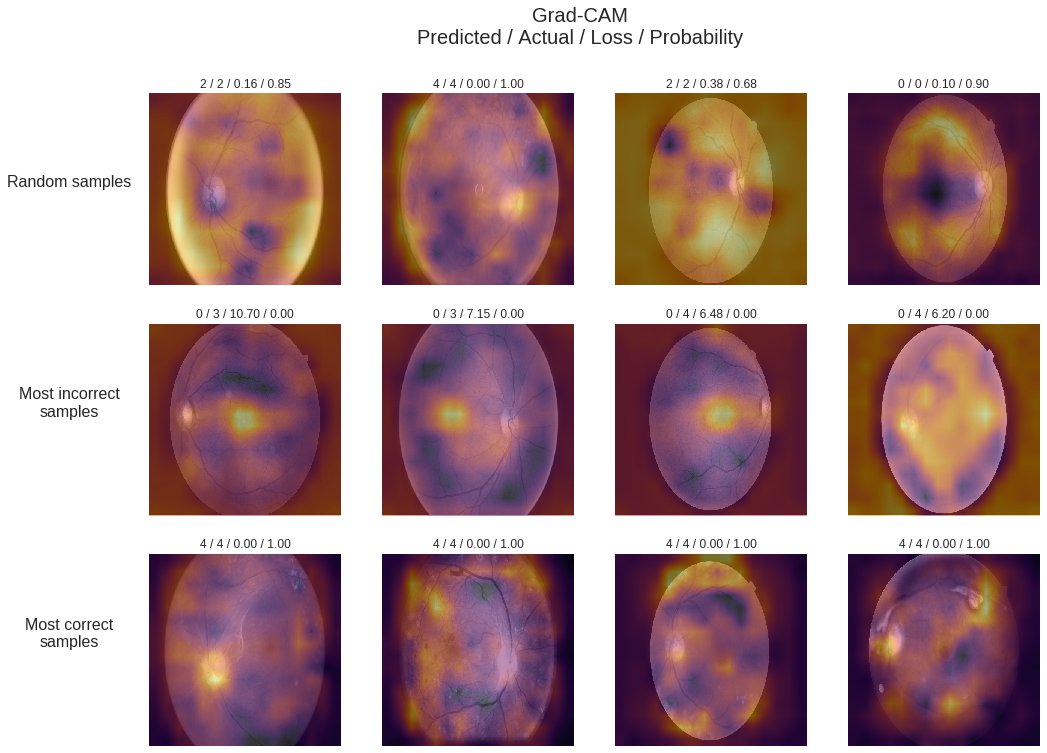

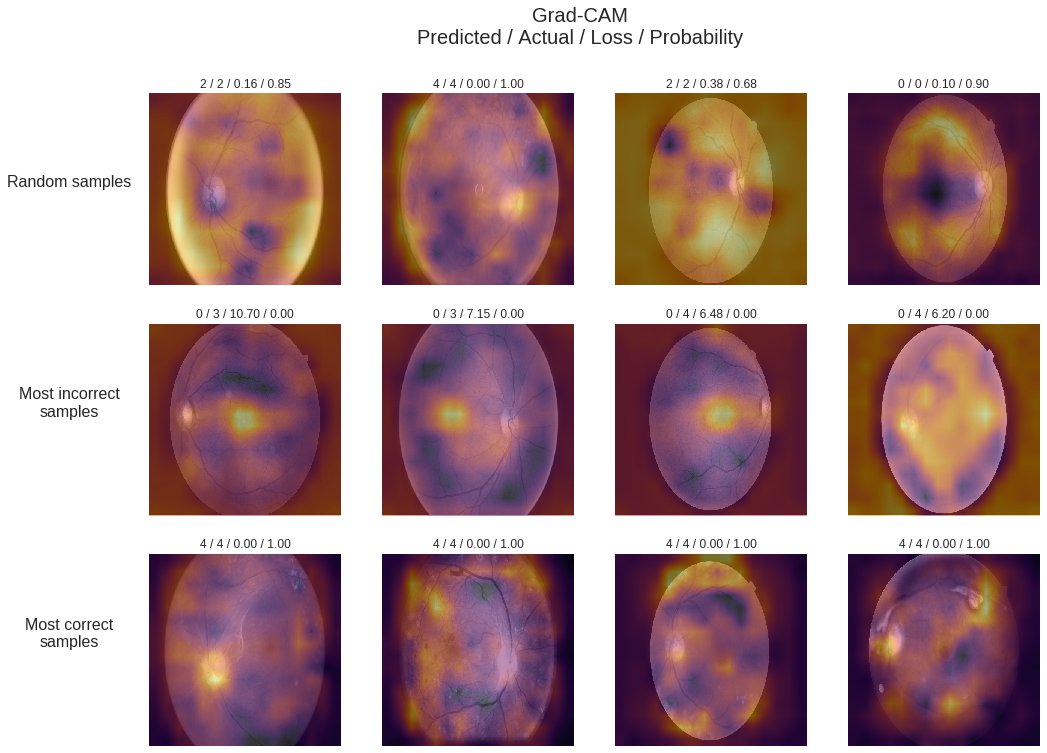

In [ ]:
plot_heatmap_overview(interp, ['0','1','2','3','4'])

In [ ]:
# saving the model to DR
learner.save('DR')